In [151]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as pjoin
from pprint import pprint as pp
import torch
from tqdm import tqdm
models_dir = "../models"
model_dirs = [models_dir + "/" + x for x in os.listdir(models_dir)]

In [203]:
def ifnotdir(dir_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)


def loss_stats_parser(loss_file,sum_over_batches=True,test_file=None):
    with open(loss_file,"r") as f:
        txt_ls = [l.strip() for l in f.readlines()]
    ls_dict = {}
    keys = []
    string = txt_ls[0].split()
    for i in range(0,9,2):
        ls_dict[string[i][:-1]] = []
        keys.append(string[i])
    for line in txt_ls:
        line = line.split()
        for i,k in zip(range(1,10,2),keys):
            k = k[:-1]
            num = line[i]
            if k in ["EPOCH","BATCH"]:
                num = int(num)
            else:
                num = np.float(num)
            ls_dict[k].append(num)
    if sum_over_batches:
        df = pd.DataFrame.from_dict(ls_dict)
        new_df = {}
        new_df["epoch"] = []
        new_df["bce"] = []
        new_df["kld"] = []
        new_df["eff"] = []
        for i in range(max(df["EPOCH"])+1):
            new_df["epoch"].append(i)
            locs = df.loc[df["EPOCH"] == i]
            new_df["bce"].append(np.sum(locs["BCE"]))
            new_df["kld"].append(np.sum(locs["KLD"]))
            new_df["eff"].append(np.sum(locs["EFF_LOSS"]))
        if test_file:
            new_df["test"] = test_loss_parser(test_file)["test_loss"]
        new_df = pd.DataFrame.from_dict(new_df)
        return new_df
    return ls_dict
            
def test_loss_parser(file):
    with open(file,"r") as f:
        txt = [l.strip() for l in f.readlines()]
    txt = np.array([t.split() for t in txt])
    data = {}
    data["epochs"] = txt[:,0]
    data["test_loss"] = txt[:,1].astype(np.float)
    return data

# txt
# txt_ls

In [205]:
def file_sorter(folder):
    name = folder.rsplit("/")[-1].split(".")[0]
    print(name)
    file_dict = {}
    file_dict["name"] = name
    file_dict["training_history"] = []
    for root,folder,files in os.walk(folder):
        files = [pjoin(root,f) for f in files]
        for file in files:
            if "loss_stats.txt" in file:
                file_dict["loss_stats"] = file
            elif "test_loss.txt" in file:
                file_dict["test_loss"] = file
            elif "progress" in file:
                file_dict["training_history"].append(file)
            elif ".pickle" in file:
                file_dict["model"] = file
    file_dict["loss_stats"] = loss_stats_parser(file_dict["loss_stats"],test_file=file_dict["test_loss"])
    return file_dict

def plot_loss(fs):
    name = fs["name"]
    new_dir = f"./plots/loss"
    if not os.path.isdir(new_dir):
        os.makedirs(new_dir)
    loss = fs["loss_stats"]["eff"]
    bce = fs["loss_stats"]["bce"]
    kld = fs["loss_stats"]["kld"]
    plt.figure(figsize=(8,8))
    plt.title(f"Loss for {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Effective Loss")
    plt.plot(loss)
#     plt.plot(bce)
#     plt.plot(kld)
    plt.savefig(new_dir+f"/{name}-loss.png")
    plt.close()
    
    
def plot_training(fs):
    name = fs["name"]
    th_dir = f"./plots/training_images/{name}"
    ifnotdir(th_dir)
    th = sorted(fs["training_history"])
    for t in tqdm(th):
        epoch = t.rsplit("/",1)[-1].rsplit(".",1)[0]
        data = []
        recons = []
        with open(t,"rb") as f:
            while True:
                try:
                    orig, recon = pickle.load(f)
                    data.append(orig)
                    recons.append(recon)
                except:
                    data = torch.vstack(data)
                    recons = torch.vstack(recons).reshape(-1,26,26)
                    break
        fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
        ax1.imshow(data[0])
        ax2.imshow(recons[0])
        plt.savefig(th_dir+f"/{epoch}.png")
        plt.close()
    
for direct in model_dirs: 
    fs = file_sorter(direct)
    plot_loss(fs)
    plot_training(fs)
    

  0%|          | 0/50 [00:00<?, ?it/s]

50epochs-15latent


100%|██████████| 50/50 [00:05<00:00,  8.66it/s]


100epochs-15latent


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


100epochs-3latent


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


150epochs-3latent


  0%|          | 0/50 [00:00<?, ?it/s]

50epochs-5latent


100%|██████████| 50/50 [00:05<00:00,  8.58it/s]


100epochs-10latent


  0%|          | 0/50 [00:00<?, ?it/s]

50epochs-3latent


100%|██████████| 50/50 [00:05<00:00,  8.68it/s]


150epochs-10latent


100%|██████████| 150/150 [00:18<00:00,  8.23it/s]


150epochs-5latent


100%|██████████| 150/150 [00:18<00:00,  7.94it/s]


150epochs-15latent


100%|██████████| 150/150 [00:19<00:00,  7.74it/s]


100epochs-5latent


  0%|          | 0/50 [00:00<?, ?it/s]

50epochs-10latent


100%|██████████| 50/50 [00:05<00:00,  8.69it/s]


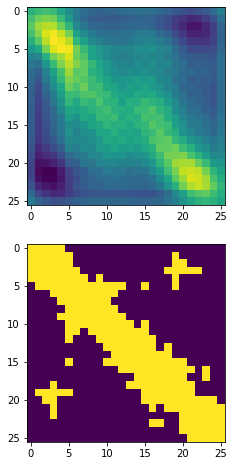

In [207]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
ax1.imshow(data[50])
ax2.imshow(recons[50])

In [187]:
recons[0].shape

torch.Size([26, 26])

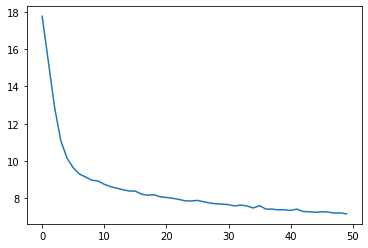

In [143]:
df = fs["loss_stats"]
df
plt.plot(df["test"])

In [190]:
fs["name"]

'50epochs-10latent'

In [ ]:
nd = {}
for i in range(0,9,2):
    nd.setdefault()
    nd[txt_ls[0].split()[i][:-1]].append(float(txt_ls[0].split()[i+1]))

In [ ]:
nd

In [ ]:
for i in range(1,10,2):
    print(i)

In [ ]:
df

True

In [111]:
np.array([t.split() for t in txt])[:,0]

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49'], dtype='<U18')

In [189]:
name

NameError: name 'name' is not defined